# 数据集定义与加载


深度学习模型需要大量的数据来完成训练和评估，这些数据样本可能是图片（image）、文本（txt）、语音（audio）等多种类型，而模型训练过程实际是数学计算过程，因此数据样本在送入模型前需要经过一系列处理，如划分数据集、变换数据形状（shape）、制作数据迭代读取器以备分批训练等。

这些处理动作可封装到函数中xxxxx，后续训练时通过xxx方式调用。归纳起来主要需定义如下几个函数：

* **定义数据集**：将磁盘中保存的原始图片、文字等样本和对应的标签映射到 Dataset，方便后续通过索引（index）读取数据，在 Dataset 中还可以进行一些数据变换、数据增广等预处理操作。在飞桨框架中推荐使用 [paddle.io.Dataset](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/Dataset_cn.html#dataset) 自定义数据集，另外在 [paddle.vision.datasets](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/text/Overview_cn.html#api) 目录下飞桨内置了一些经典数据集方便直接调用。


* **定义数据读取器**：自动将数据集的样本进行分批（batch）、乱序（shuffle）等操作，方便训练时迭代读取，同时还支持多进程异步读取功能可加快数据读取速度。在飞桨框架中可使用 [paddle.io.DataLoader](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/DataLoader_cn.html#dataloader) 迭代读取数据集。

* **（可选）定义数据采样器**：xxxxx是什么，做了什么，目的是什么。用什么接口来做。

本文以图像数据集为例介绍。


## 一、定义数据集

### 1.1 直接加载内置数据集

飞桨框架在 [paddle.vision.datasets](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/text/Overview_cn.html#api) 目录下内置了一些经典数据集可直接调用，如 CV 领域的 MNIST、Cifar10、VOC2012，NLP 领域的 Movielens、Imdb 等，通过以下代码可查看飞桨框架中的内置数据集。

In [1]:
import paddle
print('计算机视觉（CV）相关数据集：', paddle.vision.datasets.__all__)
print('自然语言处理（NLP）相关数据集：', paddle.text.__all__)

计算机视觉（CV）相关数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']
自然语言处理（NLP）相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16', 'ViterbiDecoder', 'viterbi_decode']


以 [MNIST](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/datasets/MNIST_cn.html) 数据集为例，加载内置数据集的代码示例如下所示。

In [2]:
from paddle.vision.transforms import ToTensor

# 下载数据集并初始化DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())
print('train images: ',len(train_dataset),', test images: ',len(test_dataset))

item  105/2421 [>.............................] - ETA: 2s - 1ms/item

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download


item 8/8 [============================>.] - ETA: 0s - 2ms/item


Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download

Download finished


item 116/403 [=======>......................] - ETA: 0s - 1ms/item

Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download


item 2/2 [===========================>..] - ETA: 0s - 2ms/item


Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download

Download finished


train images:  60000 , test images:  10000


内置的 [MNIST](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/datasets/MNIST_cn.html) 数据集已经划分好了训练集和测试集，通过 `mode` 字段传入 `'train'` 或 `'test'` 来区分。另外可通过 `transform` 字段传入一些对图像进行变换的操作，飞桨在 [paddle.vision.transforms](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-transforms) 里提供了一些常用的图像变换操作，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化等，这里在初始化MNIST数据集时传入了 `ToTensor` 变换来将图像转换为飞桨的内置数据类型。


完成数据集初始化之后，可以使用下面的代码直接对数据集进行迭代。

shape of image:  [1, 28, 28]


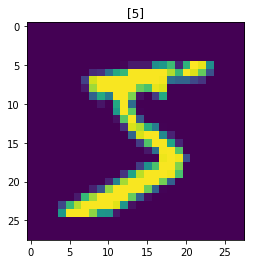

In [4]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

### 1.2 使用 paddle.io.Dataset 自定义数据集

在实际的场景中，需要使用自有的数据来定义数据集，这时可以通过飞桨提供的 `paddle.io.Dataset` 基类来实现自定义数据集。

可构建一个子类继承自 `paddle.io.Dataset` ，并且实现下面的三个函数：

1. `__init__`：完成一些数据集初始化操作，如指定数据和标签文件的存储路径、定义数据集大小等。
2. `__getitem__`：定义指定索引（index）时如何获取数据，并且在此函数中可定义一些数据预处理工作，如读取图像、对图像进行数据增强、制作标签等操作，最终返回处理好的单条数据（训练数据、对应的标签）。
3. `__len__`：返回数据集的样本总数。



In [41]:
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, num_samples, image_size=(28,28), class_num=10):
        """
        步骤二：实现 __init__ 函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.num_samples = num_samples
        self.image_size = image_size
        self.class_num = class_num

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（训练数据、对应的标签）
        """
        image = np.random.rand(*self.image_size)
        image = np.expand_dims(image, axis=0)
        label = np.random.randint(0, self.class_num - 1)

        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return self.num_samples


和内置数据集类似，可以使用下面的代码直接对自定义数据集进行迭代。

shape of image:  (1, 28, 28)


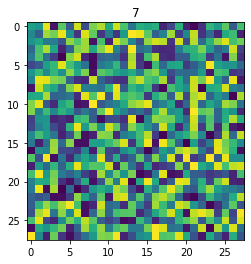

In [42]:
custom_dataset = MyDataset(BATCH_SIZE * BATCH_NUM)

for data in custom_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

### 1.3 使用 paddle.io.IterableDataset 自定义数据集

待补充

### 1.4 使用 paddle.io.TensorDataset 自定义数据集


待补充

## 二、使用 paddle.io.DataLoader 定义数据读取器


通过前面介绍的直接迭代读取 DataSet 的方式虽然可实现对数据集的访问，但是这种访问方式只能单线程进行并且还需要手动分批次（batch）。在飞桨框架中，推荐使用 [paddle.io.DataLoader](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/DataLoader_cn.html#dataloader) API 对数据集进行多进程的读取，并且可自动完成划分 batch 的工作，开发者只需要进行数据处理模块的编写。

shape of image:  [64, 1, 28, 28] shape of label:  [64, 1]


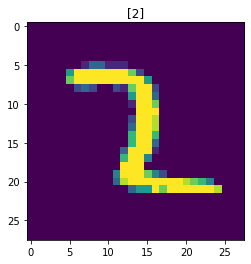

In [47]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print('shape of image: ',images.shape, 'shape of label: ', labels.shape)
    plt.title(str(labels[0].numpy()))
    plt.imshow(images[0][0])    
    break

通过上述方法，初始化了一个数据读取器 `train_loader`，用于加载训练数据集 `train_dataset`。在数据读取器中常见的几个配置如下：

* **训练样本乱序**：通过设置 `shuffle=True` ，可以在取数据前打乱样本顺序。
* **生成批次数据**：通过 `batch_size` 设置生成批次数据的批大小，示例中设置为 64。
* **同步/异步读取数据**：通过设置 `num_workers` 来设置加载数据的子进程个数，num_workers的值设为大于0时，即开启多进程方式异步加载数据，可提升数据读取速度。


## 三、定义数据采样器


待补充

## 四、总结

待补充